# Neural Variational Document Model

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Na Byeong-hu(wp03052@kaist.ac.kr); Bae Hee-sun(cat2507@kaist.ac.kr) </div> 

**본 코드는  VAE의 인공신경망 구조 (hidden layer의 개수 등)을 수정한 것으로 VAE 코드와 유사합니다.**

본 코드는 20 newsgroups 데이터셋을 이용한 NVDM(Neural Variational Document Model) 구현 예시입니다.

본 코드를 통해서 NVDM의 구조를 익힐 수 있습니다. 


## Neural Variational Inference Framework

본 모델에서는 latent variable h 가 있는 generative model을 정의합니다. 이는 deep neural network의 stochastic unit으로 고려될 수 있습니다. h의 parent와 child를 각각 x와 y로 정의한다면 generative model의 joint distribution은 다음과 같이 정의할 수 있습니다.

$p_{\theta}(x,y) = \sum_{h}p_{\theta}(y \mid h)p_{\theta}(h \mid x) p(x) = \sum_{h}p_{\theta}(x,y,h)$

이 때 $logp$의 lower bound를 L이라고 한다면, 

$logp_{\theta}(x,y)$ = $log\sum_{h}p_{\theta}(y \mid h)p_{\theta}(h \mid x) p(x)$ = $log\sum_{h}p_{\theta}(y \mid h)p_{\theta}(h \mid x) p(x) \frac{q(h)}{q(h)}$ >= $\sum_{h}  q(h)log \frac{p_{\theta}(y \mid h)p_{\theta}(h \mid x) p(x)}{q(h)}$ = $\sum_{h} q(h) [log p_{\theta}(y \mid h)p_{\theta}(h \mid x) p(x)-logq(h)] $ 이므로, 정리하면 $L = E_{q(h)}[logp_{\theta}(y \mid h)p_{\theta}(h\mid x)p(x)-logq(h)]$로 표현할 수 있습니다.

또한, $logp_{\theta}(x,y)$ = $log\sum_{h}p_{\theta}(x,y,h) \frac{q(h)}{q(h)}$ >= $\sum_{h}q(h)log\frac{p_{\theta}(x,y,h)}{q(h)}$ = $\sum_{h}q(h)logp_{\theta}(x,y,h)-q(h)logq(h)$ = $\sum_{h}q(h)logp_(x,y)p_(h\mid x,y)-q(h)logq(h)$ = $\sum_{h}q(h)logp_(x,y)-q(h)\frac{logq(h)}{logp_(h\mid x,y)} $ 이므로, q(h)가 $p(h\mid x,y) $와 최대한 유사할 때 lower bound L이 최대한 tight하다는 것을 알 수 있습니다.

$q_{\phi}(h\mid x,y) $를 diagonal Gaussian distribution이라고 하면, $\mu$와 $\sigma$는 x,y의 function입니다.
h ~ $q_{\phi}(h\mid x,y)$로부터 lower bound를 optimize하는 back-propagation을 힐 수 있습니다.


## Neural Variational Document Model

NVDM(Neural Variational Document Model)은 text의 unsupervised generative model로, 각 document에서 continuous semantic latent variable을 추출하는 것을 목표로 합니다. 이 모델은 VAE(Variational Auto-Encoder)로 해석될수 있는데, encoder가 bag-of-words document를 continuous latent distribution으로 compress하고, decoder가 softmax를 이용해 document의 모든words를 independently generate함으로써 document를 reconstruct합니다. 
구체적으로, X를 document의 bag-of-words representation, $x_{i}$를 position i의 word의 one-hot representation이라고 하고,
$q(h\mid X)$ 가 X를 hidden variable h로 compress하며(encoder), $p(X\mid h)$가 h를 $x_{i}$로 reconstruct한다고 하겠습니다(decoder).

Log-likelihood 즉, $log\sum_{h}p(X\mid h)p(h) $를 maximize하기 위해, lower bound를 보이자면,
$L=E_{q_{\phi}(h\mid X)}[\sum_{i}logp_{\theta}(x_{i}\mid h)]-D_{KL}[q_{\phi}(h\mid X)||p(h)]$ 입니다. 이 때, $p_{\theta}(x_{i}\mid h)$는 multinomial logistic regression으로 modeling되며 다음과 같이 표현될 수 있습니다.

$p_{\theta}(x_{i}\mid h)=\frac{exp[-E(x_{i};h,\theta)]}{\sum_{j} exp[-E(x_{j};h,\theta)]}$

$E(x_{i};h,\theta)=-h^T Rx_{i}-b_{x_{i}} $
R matrix는 decoder의 weight라고 생각할 수 있는데, semantic word embedding을 learn합니다.

즉 NVDM은 VAE와 구조적으로 유사하다 할 수 있으나, VAE의 decoding 과정에서 encoder를 대칭시킨 것 같은 decoder를 사용하는 것과는 다르게 softmax를 이용하여 class를 구분하여 확률을 결과로 내놓는 것에서 그 차이가 있다고 할 수 있습니다.

In [1]:
import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Na Byeong-hu: wp03052@kaist.ac.kr; Bae Hee-sun: cat2507@kaist.ac.kr
'''

class NVDM:

    network_architecture = [] # network_architecture : 인공신경망(Neural Network)의 구조를 저장
    transfer_fct = 0 #transfer_fct : 인공신경망의 transfer function을 결정

    x = [] # x : NVDM의 input, bag-of-words
    pb_x = [] # pb_x : NVDM의 output, latent variable로부터 어떤 문서에 각 단어가 존재할 확률을 나타낸다. softmax의 결과.
    z = [] # z : NVDM의 latent variable
    z_mean = [] # z_mean : NVDM의 latent variable의 mean
    z_log_sigma_sq = [] # z_log_sigma_sq : NVDM의 latent variable의 log sigma sq

    sess = 0
    cost = 0
    optimizer = 0

    def __init__(self,network_architecture,transfer_fct=tf.nn.relu):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct # activation function을 저장한다. 기본값은 relu function

        self.x = tf.placeholder(tf.float32,[None,network_architecture["n_input"]]) # input. 각 문서에 해당 단어(2000)가 몇 개 들어있는지.

    def create_network(self,batch_size):
        # NVDM을 생성하는 method
        # initialize weight -> recognition network -> Reparameterization trick -> generator network
        
        network_weights = self.initialize_weights(**self.network_architecture)
    
        self.z_mean, self.z_log_sigma_sq = self.recognition_network(network_weights["weights_recog"],network_weights["biases_recog"])

        n_z = self.network_architecture["n_z"]
        
        # Reparameteriation trick
        eps = tf.random_normal((batch_size,n_z),0,1,dtype=tf.float32)

        self.z = tf.add(self.z_mean,tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)),eps))
        
        self.R = network_weights["weights_gener"]["R"]

        self.pb_x = self.generator_network(network_weights["weights_gener"],network_weights["biases_gener"])

    def initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_input, n_z):
        # NVDM의 전체 weights의 초기값을 설정하여 dictionary로 return하는 method
        # VAE와의 차이점 : generator network의 hidden layer가 없어 n_hidden_gener가 없음
        # Input : n_hidden_recog_1, n_hidden_recog_2, n_input, n_z
        # Output : all_weights
        
        all_weights = dict()
        # Recognition Network의 weight의 초기값 설정 with Xavier initialization
        all_weights['weights_recog'] = { 'h1' : tf.Variable(self.xavier_init(n_input,n_hidden_recog_1)),\
                                        'h2' : tf.Variable(self.xavier_init(n_hidden_recog_1,n_hidden_recog_2)),\
                                        'out_mean': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z)),\
                                        'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z))}

        # Recognition Network의 bias의 초기값 설정 with 0
        all_weights['biases_recog'] = { 'b1' : tf.Variable(tf.zeros([n_hidden_recog_1],dtype=tf.float32)),\
                                       'b2' : tf.Variable(tf.zeros([n_hidden_recog_2],dtype=tf.float32)),\
                                       'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),\
                                       'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        
        # Generator Network의 weight의 초기값 설정 with Xavier initialization
        all_weights['weights_gener'] = {'R': tf.Variable(self.xavier_init(n_z, n_input))}
        
        # Generator Network의 bias의 초기값 설정 with 0
        all_weights['biases_gener'] = {'b': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights

    def recognition_network(self,weights,biases):
        # NVDM의 recognition network의 역할을 수행하는 method
        # Input : (recognition network의) weights, biases
        # Output: (z_mean, z_log_sigma_sq)
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*X)
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        z_mean = tf.add(tf.matmul(layer_2,weights['out_mean']),biases['out_mean']) # z_mean = b_{out_mean} + W_{out mean}*L2
        z_log_sigma_sq = tf.add(tf.matmul(layer_2,weights['out_log_sigma']),biases['out_log_sigma'])
        # z_log_sigma_sq = b_{out_log_sigma} + W_{out_log_sigma}*L2
        return (z_mean,z_log_sigma_sq)

    def generator_network(self,weights,biases):
        # NVDM의 generator network의 역할을 수행하는 method
        # VAE와의 차이점 : output이 x를 reconstruct하지 않고 softmax를 통해 확률로 출력
        # Input : (generator network의) weights, biases
        # Output : pb_x
        
        pb_x = tf.nn.softmax(tf.add(tf.matmul(self.z, weights['R']), biases['b']))
        # pb_x = softmax(b + R*Z)
        
        return pb_x

    def create_loss_optimizer(self,learning_rate):
        # NVDM의 total cost를 계산하고, 이를 minimize하는 optimizer를 설정하는 메소드
        # Input : learning_rate
        # Output : None
        
        # reconstruction loss function (문서 내에 있는 단어들의 log_pb을 더해야하기 때문에 self.x를 곱함)
        reconstr_loss = -tf.reduce_sum(tf.multiply(tf.log(self.pb_x),self.x),1)
        
        # latent loss function = KL-divergence
        latent_loss = -0.5*tf.reduce_sum(1+self.z_log_sigma_sq-tf.square(self.z_mean)-tf.exp(self.z_log_sigma_sq),1)
        
        # (NVDM total) cost = reconstruction loss + latent loss
        self.cost = tf.reduce_mean(reconstr_loss+latent_loss)
        
        # optimizer 설정 (Adam Optimizer 사용)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

    def partial_fit(self,x):
        # NVDM을 통하여 학습한 Input data x의 cost를 출력하는 메소드 
        # Input : x
        # Output : cost
        
        opt,cost = self.sess.run((self.optimizer,self.cost),feed_dict={self.x:x})
        return cost

    def transform(self,x):
        # NVDM의 encoder network를 통하여 latent variable z의 mean을 return하는 메소드
        # Input : x
        # Output : z_mean
        return self.sess.run(self.z_mean,feed_dict={self.x:x})

    def generate(self,z_mean=None):
        # NVDM의 decoder network를 통하여 output인 pb_x를 return하는 메소드
        # Input : z_mean
        # Output : pb_x
        if z_mean is None:
            z_mean = np.random.normal(size=self.network_architecture["n_z"])
        return self.sess.run(self.pb_x,feed_dict={self.z:z_mean})

    def reconstruct(self,x):
        # NVDM을 통하여 X를 reconstruct한 후, reconstruct pb_x를 return하는 메소드
        # Input : x
        # Output : (NVDM을 통한 reconstruct) pb_x
        return self.sess.run(self.pb_x,feed_dict={self.x:x})

    def xavier_init(self,fan_in, fan_out, constant=1): 
        # Xavier initialization method
        # Input : fan_in(들어오는 layer의 크기), fan_out(나가는 layer의 크기)
        # Output : 각 원소가 random uniform value인 (fan_in, fan_out) 형태의 tensor 
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))

        return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

    def train(self,trainX,batch_size=100,training_epochs=500,learning_rate=0.0005):
        # NVDM를 생성하고, trainX를 training하는 메소드
        # Input : trainX, batch_size, training_epochs, learning_rate
        # Output : None
        
        total_costs = np.zeros(training_epochs) # epoch당 cost를 저장할 array 
        total_perplexity = np.zeros(training_epochs) # epoch당 perplexity를 저장할 array

        self.create_network(batch_size) # NVDM 생성
        self.create_loss_optimizer(learning_rate) # NVDM의 loss function과 optimizer 생성

        init = tf.global_variables_initializer()
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
        self.sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        # session : tensorflow를 올려놓아 실행을 진행하기 위한 공간
        self.sess.run(init)

        startTime = time.time()
        for epoch in range(training_epochs): # training_epochs만큼 반복 실행
            avg_cost = 0. # training set의 average cost를 저장
            avg_perplexity = 0. # training set의 average perplexity를 저장
            total_batch = int(len(trainX)/batch_size) # 전체 batch의 갯수

            for i in range(total_batch): # total_batch만큼 반복 실행
                batch = []
                for j in range(batch_size): # trainX에서 i번째 batch를 가져오는 과정
                    batch.append(trainX[i*batch_size+j])
                cost = self.partial_fit(batch) # i번째 batch의 cost 계산
                avg_cost += cost / total_batch
                avg_perplexity += cost / (total_batch * (sum(map(sum,batch))/batch_size))

            total_costs[epoch] = avg_cost # epoch의 cost를 계산하여 저장
            total_perplexity[epoch] = np.exp(avg_perplexity) # epoch의 perplexity를 계산하여 저장

            print("Epoch : ",'%04d'%(epoch+1)," Cost = ","{:.9f}".format(avg_cost)," training perplexity = ","{:.9f}".format(np.exp(avg_perplexity)))
            print("Elapsed Time : " + str((time.time() - startTime)))

        # epoch에 대한 cost 변화를 그래프로 표현
        plt.plot(total_costs) 
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()
        return
    
    def test(self,testX,batch_size=1):
        # 학습된 NVDM을 testX 데이터를 이용하여 testing하는 메소드
        # Input : testX, batch_size
        # Output : None

        avg_perplexity = 0. # testing set의 average perplexity를 저장
        total_batch = int(len(testX)/batch_size) # 전체 batch의 갯수

        for i in range(total_batch): # total_batch만큼 반복 실행
            batch = []
            for j in range(batch_size): # testX에서 i번째 batch를 가져오는 과정
                batch.append(testX[i*batch_size+j])
            cost = self.sess.run(self.cost,feed_dict={self.x:batch})
            avg_perplexity += cost / (total_batch * (sum(map(sum,batch))/batch_size))

        print("testing perplexity = ","{:.9f}".format(np.exp(avg_perplexity)))
        return
    
    def topic_words(self, num_words=10):
        # 학습된 NVDM의 R 행렬을 통하여 topic별 대표 단어를 뽑아내는 메소드
        # Input : num_words
        # Output : None
        
        R = self.sess.run(self.R)
        top = [[] for _ in range(len(R))]
        
        print("Top ",'%2d'%(num_words)," words in each topic\n")
        
        for i in range(len(R)):
            index = (-R[i]).argsort()
            top_idx = index[:num_words]
            s = 'Topic %2d : '%(i + 1)
            for word in bagVocab[top_idx]:
                s += ' %s,' % (word)
            print(s[:-1])

## NVDM with 50 dimension of latent space

In [3]:
print("Data loading start!")

bagVocab = np.load('bagVocab_3+_newstop_tfidf.npy') # 사용할 단어 목록을 정리한 파일 load (3글자 이상, stop words가 제거된 tf-idf 상위 2000개 단어)
vect = CountVectorizer(vocabulary=bagVocab, binary=True)  # 단어를 count하는 방법 설정

# training 데이터를 세팅하는 과정
newsgroups_train = fetch_20newsgroups(subset='train',shuffle=True, random_state=0) # '20newsgroups' train 데이터셋을 load
data = vect.fit_transform(newsgroups_train.data)  # 각 문서별 단어 개수 세기 진행

trainX = []
for i in range(data.shape[0]): # data.shape[0] = 문서 개수 / sparse matrix 파일형식으로 설정된 data를 tuple로 변환하는 과정
    tempdata = data[i].toarray()
    temptuple = tuple(map(tuple,tempdata))[0]
    trainX.append(temptuple)

# testing 데이터를 세팅하는 과정
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=0) # '20newsgroups' test 데이터셋을 load
data_test = vect.fit_transform(newsgroups_test.data) # 각 문서별 단어 개수 세기 진행

testX = []
for i in range(data_test.shape[0]): # data.shape[0] = 문서 개수 / sparse matrix 파일형식으로 설정된 data를 tuple로 변환하는 과정
    tempdata = data_test[i].toarray()
    temptuple = tuple(map(tuple,tempdata))[0]
    testX.append(temptuple)

print("Data loading finished!")



Data loading start!
Data loading finished!


Epoch :  0001  Cost =  413.465723358  training perplexity =  1589.166116341
Elapsed Time : 32.135401248931885
Epoch :  0002  Cost =  400.680911984  training perplexity =  1262.786851761
Elapsed Time : 67.58098793029785
Epoch :  0003  Cost =  397.345879209  training perplexity =  1189.855703660
Elapsed Time : 107.31324648857117
Epoch :  0004  Cost =  395.042668435  training perplexity =  1142.025310856
Elapsed Time : 137.18315362930298
Epoch :  0005  Cost =  393.393789916  training perplexity =  1108.856345489
Elapsed Time : 172.721421957016
Epoch :  0006  Cost =  391.849370636  training perplexity =  1078.633179098
Elapsed Time : 192.7139813899994
Epoch :  0007  Cost =  390.632992635  training perplexity =  1055.353319352
Elapsed Time : 224.7656397819519
Epoch :  0008  Cost =  389.627024423  training perplexity =  1036.683404083
Elapsed Time : 251.59528613090515
Epoch :  0009  Cost =  388.672182606  training perplexity =  1019.344533119
Elapsed Time : 281.761027097702
Epoch :  0010  Co

Epoch :  0077  Cost =  370.832965952  training perplexity =  740.644817369
Elapsed Time : 1955.5225138664246
Epoch :  0078  Cost =  370.814502817  training perplexity =  740.497210744
Elapsed Time : 1987.963355064392
Epoch :  0079  Cost =  370.789960743  training perplexity =  740.197019139
Elapsed Time : 2013.107965707779
Epoch :  0080  Cost =  370.789299349  training perplexity =  740.139887598
Elapsed Time : 2036.4815905094147
Epoch :  0081  Cost =  370.610413948  training perplexity =  737.667488381
Elapsed Time : 2060.3429362773895
Epoch :  0082  Cost =  370.685553087  training perplexity =  738.715945821
Elapsed Time : 2081.513822078705
Epoch :  0083  Cost =  370.516836791  training perplexity =  736.431796283
Elapsed Time : 2104.4916734695435
Epoch :  0084  Cost =  370.487828348  training perplexity =  736.232547861
Elapsed Time : 2126.2921979427338
Epoch :  0085  Cost =  370.361386459  training perplexity =  734.517829855
Elapsed Time : 2149.0171933174133
Epoch :  0086  Cost = 

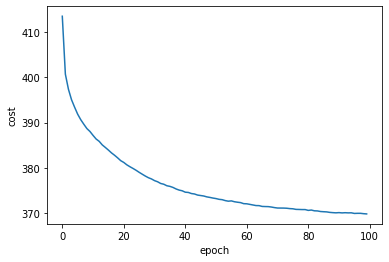

In [4]:
np.random.seed(0)
tf.set_random_seed(0)

# input(2000) -> h1(500) -> h2(500) -> z(50) -> output(2000)
network_architecture = dict(n_hidden_recog_1=500, n_hidden_recog_2=500, n_input=data.shape[1], n_z=50)

nvdm = NVDM(network_architecture)
nvdm.train(trainX,batch_size=100,training_epochs=100,learning_rate=0.001) # NVDM training

### 결과해석부1

위의 출력 결과는 20NewsGroups 데이터셋을 이용해 50차원 document representation NVDM으로 학습한 결과입니다.

20NewsGroups 데이터셋은 약 18,000개의 newsgroups posts을 20개의 토픽으로 분류해 놓은 데이터셋으로, 특정 날짜를 기준으로 training 게시글과 testing 게시글로 나뉘어져 있습니다.
위 모델에서는 모든 게시글의 단어 중 stop words를 제외하고 3글자 이상의 단어의 TF-IDF 값 상위 2,000개의 단어만을 사용했습니다.
위 모델의 Encoder는 2개의 500차원 Hidden Layer(activation function : ReLU)를 가진 MLP이며 batch size는 100, epoch size는 100, learning rate는 0.001입니다.

출력문은 각 epoch의 average cost와 traning perplexity, 실행 소요 시간을 나타냈습니다. 출력문 아래의 그래프는 x축은 epoch, y축은 cost로 epoch이 진행되면서 cost의 변화를 그래프로 표현한 것입니다. 

perplexity란 topic modeling에서 성능을 평가하기 위해 사용하는 지표인데, $exp(-\frac{1}{D} \sum_{n}^N \frac{1}{N_{d}}logp(X_{d}))$(단 D는 document의 개수, $N_{d}$는 dth document의 단어의 개수) 로 계산합니다. 단, NVDM에서는 logp(X)를 구하기 힘드므로, variational lower bound로 대체하면 perplexity의 upper bound를 계산할 수 있습니다.


그래프에서 알 수 있듯이, 학습이 진행되면서(epoch이 증가하면서) cost/perplexity가 꾸준히 감소함을 알 수 있습니다. 
이를 통해서 cost 식이 감소하는 방향으로 학습이 잘 진행되고 있음을 알 수 있습니다.

## Calculation of Perplexity

In [5]:
print("==============================================")
nvdm.test(testX) # NVDM testing
print("==============================================")
nvdm.topic_words()  # topic별로 단어를 보여준다.

testing perplexity =  726.911605288
Top  10  words in each topic

Topic  1 :  rob, rice, saturn, bios, thor, split, wait, convex, caused, answers
Topic  2 :  bradley, csd, midway, utk, win, gatech, ati, hurt, chicago, manager
Topic  3 :  princeton, rit, sports, saturn, sas, philadelphia, isc, society, turbo, thor
Topic  4 :  upenn, psuvm, cunixb, psu, sas, seas, ide, master, genesis, arabs
Topic  5 :  forward, bunch, replies, players, excuse, stats, digex, compare, greg, maynard
Topic  6 :  experiences, ncsu, anderson, heavy, eff, minnesota, eos, staff, greatly, employer
Topic  7 :  adapter, buffalo, mary, stratus, chi, slot, devils, dare, ide, bus
Topic  8 :  lord, christ, church, christians, father, catholic, jewish, scripture, greek, athos
Topic  9 :  patients, medicine, boeing, vnews, activities, udel, vax, communication, kent, sandvik
Topic 10 :  jobs, citizens, budget, thor, congress, americans, clinton, tax, social, health
Topic 11 :  francisco, rider, frank, jose, guest, motorc

### 결과해석부2

출력문을 통해 testing perplexity가 726.91로 나타남을 알 수 있습니다. testing set을 이용해 학습된 모델의 perplexity를 계산한 것으로, 다른 document model과 성능 비교를 할 때, 이 수치를 이용할 수 있습니다.

latent variable의 각 dimension이 각각 하나의 Topic을 뜻한다고 가정하겠습니다. 따라서 Topic은 50개가 됩니다. 그 이후 모델을 통해 학습된 각 주제의 상위 10개 단어를 결과로 나타내겠습니다. 이는 각 dimension이 어떤 단어에 큰 확률을 가지는 지를 뜻합니다. 즉, R matrix의 각 row가 Topic이 되고 column이 단어가 되어 row별로 값이 큰 단어를 차례대로 나타낸 것입니다.
예를 들어, topic 8에서 주로 christian에 관한 단어들이 대표 단어로 추출되었습니다. 이를 통해 topic 8이 20NewsGroups 데이터셋의 토픽 중 'soc.religion.christian'에 관한 기사들을 잘 모은 것을 알 수 있습니다.